Import Block

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

Data Exploratory


In [2]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/christiandoxa/usahaq_ml/master/Dataset/Dataset%20Bahan%20Pokok/daftar-harga-gula-pasir-lokal-malang-2017-2021.csv?token=ARB4LTCUF2GC5IKMNSU4KG3AX3G5O \
    -O /tmp/sugar.csv

--2021-06-01 02:07:48--  https://raw.githubusercontent.com/christiandoxa/usahaq_ml/master/Dataset/Dataset%20Bahan%20Pokok/daftar-harga-gula-pasir-lokal-malang-2017-2021.csv?token=ARB4LTCUF2GC5IKMNSU4KG3AX3G5O
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15929 (16K) [text/plain]
Saving to: ‘/tmp/sugar.csv’

/tmp/sugar.csv      100%[===================>]  15.56K  --.-KB/s    in 0.001s  

2021-06-01 02:07:48 (23.8 MB/s) - ‘/tmp/sugar.csv’ saved [15929/15929]



In [3]:
#Read dataset with pandas, then put it to sugar_df variable
sugar_df = pd.read_csv('/tmp/sugar.csv')
sugar_df

tanggal  harga
0    2017-08-02  10750
1    2017-08-03  10750
2    2017-08-04  10750
3    2017-08-07  10750
4    2017-08-08  10750
..          ...    ...
935  2021-05-24  11450
936  2021-05-25  11450
937  2021-05-27  11450
938  2021-05-28  11450
939  2021-05-31  11450

[940 rows x 2 columns]

In [4]:
#Inspect the first 5 of sugar_df dataframe
sugar_df.head()

tanggal  harga
0  2017-08-02  10750
1  2017-08-03  10750
2  2017-08-04  10750
3  2017-08-07  10750
4  2017-08-08  10750

In [5]:
#Inspect the last 5 of sugar_df dataframe
sugar_df.tail()

tanggal  harga
935  2021-05-24  11450
936  2021-05-25  11450
937  2021-05-27  11450
938  2021-05-28  11450
939  2021-05-31  11450

In [6]:
#Inspect the describtion of sugar_df dataframe
sugar_df.describe()

harga
count    940.000000
mean   11355.638298
std     1420.641277
min     9600.000000
25%    10700.000000
50%    11250.000000
75%    11650.000000
max    17450.000000

In [7]:
#Casting harga's column to float
sugar_df['harga'] = pd.to_numeric(sugar_df['harga'], downcast='float')
print(sugar_df)
print(sugar_df.dtypes)

        tanggal    harga
0    2017-08-02  10750.0
1    2017-08-03  10750.0
2    2017-08-04  10750.0
3    2017-08-07  10750.0
4    2017-08-08  10750.0
..          ...      ...
935  2021-05-24  11450.0
936  2021-05-25  11450.0
937  2021-05-27  11450.0
938  2021-05-28  11450.0
939  2021-05-31  11450.0

[940 rows x 2 columns]
tanggal     object
harga      float32
dtype: object


In [8]:
#Normalize harga's column data by dividing it with the largest number
max = sugar_df['harga'].max()
sugar_df['harga'] /= max

In [9]:
sugar_df

tanggal     harga
0    2017-08-02  0.616046
1    2017-08-03  0.616046
2    2017-08-04  0.616046
3    2017-08-07  0.616046
4    2017-08-08  0.616046
..          ...       ...
935  2021-05-24  0.656160
936  2021-05-25  0.656160
937  2021-05-27  0.656160
938  2021-05-28  0.656160
939  2021-05-31  0.656160

[940 rows x 2 columns]

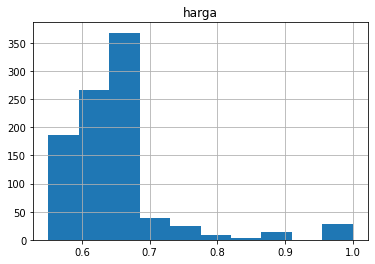

In [10]:
_ = sugar_df.hist()

In [11]:
#Get the price and time step from dataframe
temp = sugar_df['harga']
price = np.array(temp.tolist())
time = np.array([i[0] for i in enumerate(price)])

In [12]:
#Helper function for plotting dataset
def plot_dataset(time, series, title, xlabel, ylabel, color='b'):
  plt.plot(time, series, '{}-'.format(color))
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.grid=True

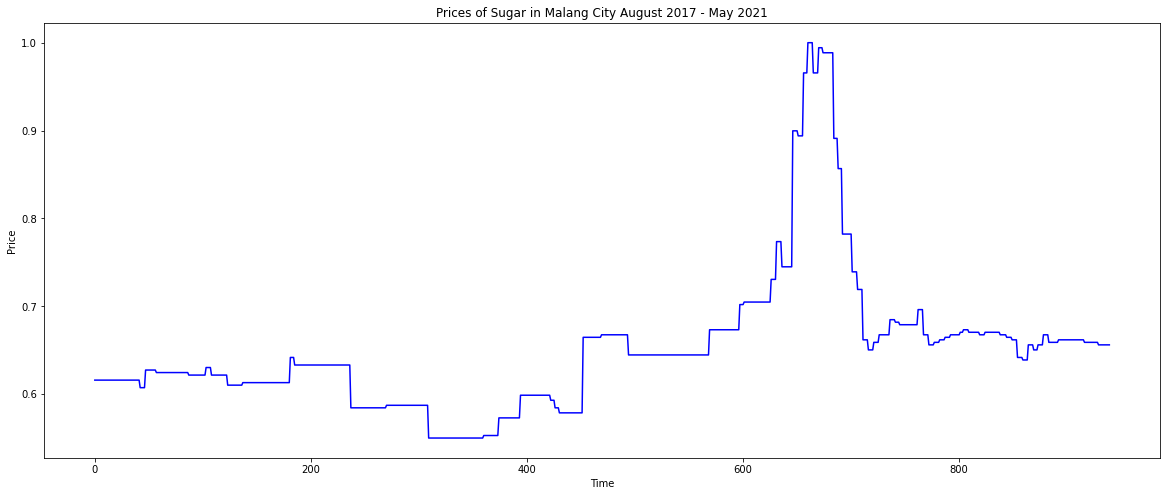

In [13]:
#Plot the dataset
plt.figure(figsize=(20, 8))
plot_dataset(time=time, series=price, color='b', title='Prices of Sugar in Malang City August 2017 - May 2021', xlabel='Time', ylabel='Price')

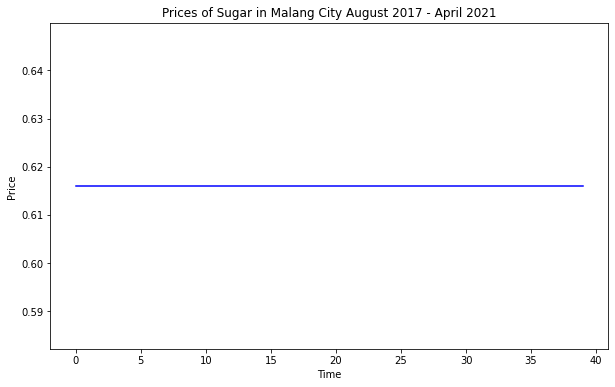

In [14]:
plt.figure(figsize=(10, 6))
plot_dataset(time=time[:40], series=price[:40], color='b', title='Prices of Sugar in Malang City August 2017 - April 2021', xlabel='Time', ylabel='Price')

Split Train and Test

In [15]:
#Split dataset with 70% of training, 20% for validation, and the rest for testing
split = round(0.7*len(price))
split_val = round(0.9*len(price))
train_price = price[:split]
train_time = time[:split]
val_price = price[split:split_val]
val_time = time[split:split_val]
test_price = price[split_val:]
test_time = time[split_val:]

Window the Dataset 

In [16]:
#Helper function for windowing the dataset
def dataset_window(list, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(temp, axis=-1)
  data_window = tf.data.Dataset.from_tensor_slices(series)
  data_window = data_window.window(window_size + 1, shift = 1, drop_remainder= True)
  data_window = data_window.flat_map(lambda x: x.batch(window_size+1))
  data_window = data_window.shuffle(shuffle_buffer)
  data_window = data_window.map(lambda x: (x[:-1], x[1:]))
  data_window = data_window.batch(batch_size).prefetch(1)
  return data_window

Function for Forecasting the Model for Fit It Into the Plotted Graph

In [17]:
#Helper function for forecasting
def forecast_model(model, series, window_size):
  data_forecast = tf.data.Dataset.from_tensor_slices(series)
  data_forecast = data_forecast.window(window_size, shift=1, drop_remainder=True)
  data_forecast = data_forecast.flat_map(lambda x: x.batch(window_size))
  data_forecast = data_forecast.batch(32).prefetch(1)
  print(data_forecast)
  forecast = model.predict(data_forecast)
  return forecast

Window Size, Batch Size, & Shuffle Buffer

In [18]:
window_size = 40
batch_size = 512
shuffle_buffer = 1000

Build the Model

In [19]:
#Building model with learning rate scheduler, so we can pick the best learning rate
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = dataset_window(train_price, window_size, batch_size, shuffle_buffer)

print(train_set)
print(train_price.shape)

model = tf.keras.models.Sequential([
          tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1,
                                 padding='causal', activation='relu',
                                 input_shape=[None,1]),
          tf.keras.layers.LSTM(32, return_sequences=True),
          tf.keras.layers.LSTM(16, return_sequences=True),
          tf.keras.layers.Dense(16, activation='relu'),
          tf.keras.layers.Dense(1),
])
learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(
    lambda x: 1e-8 * 10**(x/20))
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9),
              metrics=[tf.metrics.MeanAbsoluteError()])
history = model.fit(train_set, epochs=200, callbacks=[learning_rate_scheduler])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float32, tf.float32)>
(658,)
Epoch 1/200
2/2 [==============================] - 34s 121ms/step - loss: 0.2461 - mean_absolute_error: 0.6958
Epoch 2/200
2/2 [==============================] - 0s 17ms/step - loss: 0.2461 - mean_absolute_error: 0.6958
Epoch 3/200
2/2 [==============================] - 0s 18ms/step - loss: 0.2461 - mean_absolute_error: 0.6958
Epoch 4/200
2/2 [==============================] - 0s 13ms/step - loss: 0.2461 - mean_absolute_error: 0.6958
Epoch 5/200
2/2 [==============================] - 0s 10ms/step - loss: 0.2461 - mean_absolute_error: 0.6958
Epoch 6/200
2/2 [==============================] - 0s 18ms/step - loss: 0.2461 - mean_absolute_error: 0.6958
Epoch 7/200
2/2 [==============================] - 0s 12ms/step - loss: 0.2461 - mean_absolute_error: 0.6958
Epoch 8/200
2/2 [==============================] - 0s 12ms/step - loss: 0.2461 - mean_absolute_error: 0.6958
Epoch 9/200
2/2 [========

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
lstm (LSTM)                  (None, None, 32)          8320      
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 16)          3136      
_________________________________________________________________
dense (Dense)                (None, None, 16)          272       
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           17        
Total params: 11,937
Trainable params: 11,937
Non-trainable params: 0
_________________________________________________________________


(0.0001, 0.1, 0.0, 0.2)

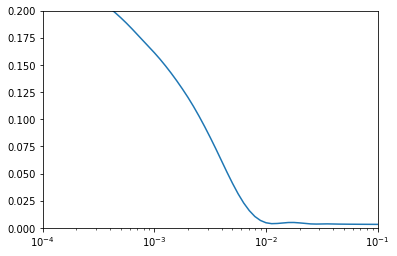

In [21]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 0.2])

In [19]:
#Build the final model with the best learning rate
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = dataset_window(train_price, window_size, batch_size, shuffle_buffer)
val_set = dataset_window(val_price, window_size, batch_size, shuffle_buffer)
print(train_set)
print(train_price.shape)

model = tf.keras.models.Sequential([
          tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1,
                                 padding='causal', activation='relu',
                                 input_shape=[None,1]),
          tf.keras.layers.LSTM(32, return_sequences=True),
          tf.keras.layers.LSTM(16, return_sequences=True),
          tf.keras.layers.Dense(16, activation='relu'),
          tf.keras.layers.Dense(1),
])
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-1, momentum=0.9),
              metrics=[tf.metrics.MeanAbsoluteError()])
history = model.fit(train_set, epochs=500, validation_data=val_set)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float32, tf.float32)>
(658,)
Epoch 1/500
2/2 [==============================] - 35s 878ms/step - loss: 0.1556 - mean_absolute_error: 0.5432 - val_loss: 0.0101 - val_mean_absolute_error: 0.0961
Epoch 2/500
2/2 [==============================] - 0s 137ms/step - loss: 0.0214 - mean_absolute_error: 0.1615 - val_loss: 0.0853 - val_mean_absolute_error: 0.3902
Epoch 3/500
2/2 [==============================] - 0s 129ms/step - loss: 0.0726 - mean_absolute_error: 0.3578 - val_loss: 0.0150 - val_mean_absolute_error: 0.1607
Epoch 4/500
2/2 [==============================] - 0s 135ms/step - loss: 0.0106 - mean_absolute_error: 0.1183 - val_loss: 0.0170 - val_mean_absolute_error: 0.1650
Epoch 5/500
2/2 [==============================] - 0s 133ms/step - loss: 0.0221 - mean_absolute_error: 0.1919 - val_loss: 0.0302 - val_mean_absolute_error: 0.2324
Epoch 6/500
2/2 [==============================] - 0s 142ms/step - loss: 0.0259 - m

In [20]:
#Forecasting the testing data
rnn_forecast = forecast_model(model, price[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_val - window_size:-1, -1, 0]

<PrefetchDataset shapes: (None, None, 1), types: tf.float64>


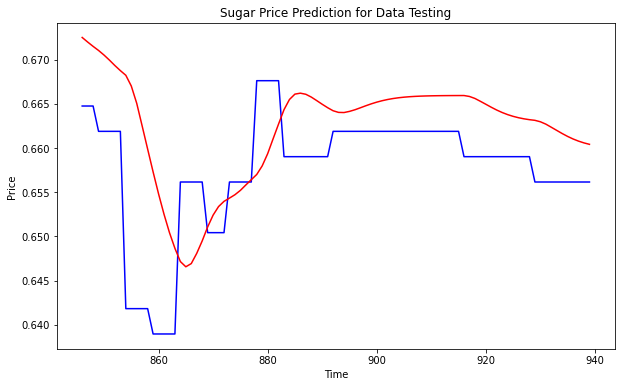

In [21]:
#Plotting the testing data
plt.figure(figsize=(10, 6))
plot_dataset(time=test_time, series=test_price, title='Sugar Price Prediction for Data Testing',xlabel='Time', ylabel='Price')
plot_dataset(time=test_time, series=rnn_forecast, title='Sugar Price Prediction for Data Testing', xlabel='Time', ylabel='Price', color='r')

<Figure size 432x288 with 0 Axes>

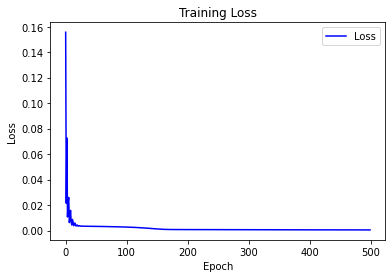

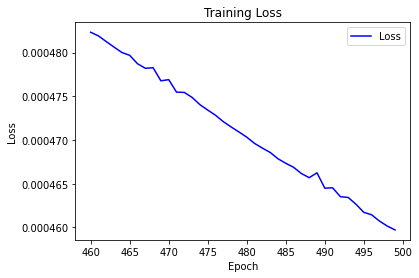

<Figure size 432x288 with 0 Axes>

In [23]:
#Plotting and examining the training loss
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss=history.history['loss']

epoch_num=range(len(loss))

plot_dataset(epoch_num, loss, title='Training Loss', xlabel='Epoch', ylabel='Loss')
plt.legend(["Loss"])
plt.figure()

loss_zoom = loss[460:]
epoch_num_zoom = [x+460 for x in range(len(loss_zoom))]

plot_dataset(epoch_num_zoom, loss_zoom, title='Training Loss', xlabel='Epoch', ylabel='Loss')
plt.legend(["Loss"])
plt.figure()

In [24]:
rnn_forecast

array([0.67251176, 0.6719955 , 0.67150486, 0.6710422 , 0.6705229 ,
       0.66994566, 0.66933113, 0.66876024, 0.6682335 , 0.6670209 ,
       0.66505814, 0.6624831 , 0.6598841 , 0.65730476, 0.65482056,
       0.65251595, 0.6504365 , 0.6486583 , 0.6471591 , 0.64656997,
       0.646932  , 0.64808923, 0.64949423, 0.65107113, 0.65241224,
       0.65338147, 0.65397125, 0.65433884, 0.65472025, 0.6552109 ,
       0.6558233 , 0.6564207 , 0.6570114 , 0.65798306, 0.65935814,
       0.661049  , 0.6627175 , 0.66434145, 0.66549677, 0.66610247,
       0.6662099 , 0.6660845 , 0.6657684 , 0.6653688 , 0.6649556 ,
       0.6645667 , 0.66422147, 0.6640347 , 0.66401833, 0.6641483 ,
       0.66433215, 0.66455626, 0.66478664, 0.6650026 , 0.6651945 ,
       0.6653583 , 0.665494  , 0.66560376, 0.6656904 , 0.66575706,
       0.6658077 , 0.66584593, 0.6658742 , 0.665895  , 0.66591024,
       0.6659212 , 0.6659291 , 0.66593456, 0.6659383 , 0.6659409 ,
       0.6659427 , 0.665837  , 0.6656128 , 0.6652905 , 0.66495

In [25]:
temp = len(test_price)-21
temp_1 = len(test_price)-1
temp=test_price[temp:temp_1]

In [26]:
rnn_forecast = forecast_model(model, temp[..., np.newaxis],len(temp)).tolist()
rnn_forecast

<PrefetchDataset shapes: (None, None, 1), types: tf.float64>


[[[0.6559694409370422],
  [0.6503092646598816],
  [0.6492193341255188],
  [0.6477102637290955],
  [0.6514430046081543],
  [0.6564655900001526],
  [0.6608964204788208],
  [0.6640599966049194],
  [0.6658942103385925],
  [0.6666224002838135],
  [0.6664740443229675],
  [0.6663318872451782],
  [0.6658157110214233],
  [0.6640620827674866],
  [0.6620850563049316],
  [0.660434901714325],
  [0.6591352224349976],
  [0.6581738591194153],
  [0.6575176119804382],
  [0.6571218967437744]]]

In [27]:
round(rnn_forecast[-1][-1][0]*max)

11467

In [28]:
model.save("sugar_model")

INFO:tensorflow:Assets written to: sugar_model/assets


INFO:tensorflow:Assets written to: sugar_model/assets


In [29]:
!zip -r sugar_model.zip sugar_model

  adding: sugar_model/ (stored 0%)
  adding: sugar_model/assets/ (stored 0%)
  adding: sugar_model/keras_metadata.pb (deflated 91%)
  adding: sugar_model/saved_model.pb (deflated 89%)
  adding: sugar_model/variables/ (stored 0%)
  adding: sugar_model/variables/variables.data-00000-of-00001 (deflated 16%)
  adding: sugar_model/variables/variables.index (deflated 66%)
